In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import logging 
logging.basicConfig(level=logging.INFO)
import atlite

In [35]:
filename="/groups/EXTREMES/cutouts/europe-2016-era5.nc"
ds_era5_2016 = xr.open_dataset(filename)
ds_sarah="/groups/EXTREMES/SARAH-3/europe-1996-sarah3-era5.nc"
ds_sarah=xr.open_dataset(ds_sarah)

In [5]:
ds_era5_2016

<xarray.Dataset> Size: 17GB
Dimensions:           (x: 189, y: 157, time: 8784)
Coordinates:
  * x                 (x) float64 2kB -12.0 -11.75 -11.5 ... 34.5 34.75 35.0
  * y                 (y) float64 1kB 33.0 33.25 33.5 33.75 ... 71.5 71.75 72.0
  * time              (time) datetime64[ns] 70kB 2016-01-01 ... 2016-12-31T23...
    lon               (x) float64 2kB ...
    lat               (y) float64 1kB ...
Data variables: (12/13)
    height            (y, x) float32 119kB ...
    wnd100m           (time, y, x) float32 1GB ...
    wnd_azimuth       (time, y, x) float32 1GB ...
    roughness         (time, y, x) float32 1GB ...
    influx_toa        (time, y, x) float32 1GB ...
    influx_direct     (time, y, x) float32 1GB ...
    ...                ...
    albedo            (time, y, x) float32 1GB ...
    solar_altitude    (time, y, x) float64 2GB ...
    solar_azimuth     (time, y, x) float64 2GB ...
    temperature       (time, y, x) float64 2GB ...
    soil temperature  (time, y, x) float64 2GB ...
    runoff            (time, y, x) float32 1GB ...
Attributes:
    module:             era5
    prepared_features:  ['influx', 'temperature', 'runoff', 'height', 'wind']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-02-20 09:11:45 GMT by grib_to_netcdf-2.25.1: /op...

In [30]:
from regridding_functions import read_and_average_era5_4y, read_and_average_sarah, regrid

In [31]:
def fill_nans_with_last_valid(bias_factor):
    #for Sarah, fills the Nan values of the bias factor along the latitude axis with the last valid value
    for lon in range(bias_factor.shape[1]):  # Iterate over longitudes (second axis)
        valid_values = ~np.isnan(bias_factor[:, lon])  # Find valid (non-NaN) indices along latitude
        if np.any(valid_values):  # If there's at least one valid value
            last_valid_idx = np.max(np.where(valid_values))  # Get the last valid latitude index
            bias_factor[last_valid_idx+1:, lon] = bias_factor[last_valid_idx, lon]  # Fill NaNs downward
    
    return bias_factor

def bias_factor_era5_sarah(var):
    #calculates the bias factor between era5 and sarah for the variable var, for now only 4 years data
    rsds_era5_mean_4y= read_and_average_era5_4y(var) #read and av the 4 years of era5 for bias correction with sarah
    rsds_sarah_mean= read_and_average_sarah(var) #same for sarah
    rsds_era5_mean_cut=rsds_era5_mean_4y.sel(x=slice(-12, 35), y=slice(33, 64.8)) #cut to the max latitude covered by sarah
    rsds_sarah_mean_cut=rsds_sarah_mean.sel(x=slice(-12, 35), y=slice(33, 64.8))
    regridder=regrid(rsds_era5_mean_cut, rsds_sarah_mean_cut, method='conservative')  #regrid era5 (0.25x0.25) to the sarah grid (0.3x0.3)
    rsds_era5_mean_interp_cut_4y=regridder(rsds_era5_mean_cut)
    denominator_era5_sarah= rsds_era5_mean_interp_cut_4y.values  # ERA5 dataset
    numerator_era5_sarah= rsds_sarah_mean_cut.values  # SARAH dataset
    # Ensure valid bias factor calculation
    mask_valid = (denominator_era5_sarah != 0) & (numerator_era5_sarah != 0) # Avoid division by zero and all values in sarah that have mean 0
    bias_factor_era5_sarah = np.where(mask_valid, numerator_era5_sarah / denominator_era5_sarah, np.nan)  # Replace invalid cases with NaN
    #bias_factor_era5_sarah = fill_nans_with_last_valid(bias_factor_era5_sarah)  # Fill NaNs downward
    print(f"Shape of bias_factor_era5_sarah: {bias_factor_era5_sarah.shape}")
    return bias_factor_era5_sarah

In [32]:
var="influx_direct"
bias_factor_era5_sarah_direct=bias_factor_era5_sarah(var)

['/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc', '/groups/EXTREMES/cutouts/europe-2012-era5.nc', '/groups/EXTREMES/cutouts/europe-2013-era5.nc']
['/groups/EXTREMES/SARAH-3/europe-1996-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2012-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2013-sarah3-era5.nc']
189 190
128 129
157 158
107 108


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_direct as the horizontal dimensions for the regridding.
  warnings.warn(


Shape of bias_factor_era5_sarah: (107, 157)


In [33]:
var="influx_diffuse"
bias_factor_era5_sarah_diffuse=bias_factor_era5_sarah(var)

['/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc', '/groups/EXTREMES/cutouts/europe-2012-era5.nc', '/groups/EXTREMES/cutouts/europe-2013-era5.nc']
['/groups/EXTREMES/SARAH-3/europe-1996-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2012-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2013-sarah3-era5.nc']
189 190
128 129
157 158
107 108


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_diffuse as the horizontal dimensions for the regridding.
  warnings.warn(


Shape of bias_factor_era5_sarah: (107, 157)


In [39]:
regridder=regrid(ds_era5_2016, ds_sarah, method='conservative')  #regrid era5 (0.25x0.25) to the sarah grid (0.3x0.3)
ds_era5_2016=regridder(ds_era5_2016)

177 178
131 132
177 178
131 132


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable height as the horizontal dimensions for the regridding.
  warnings.warn(


In [43]:
ds_sarah

<xarray.Dataset> Size: 13GB
Dimensions:           (x: 177, y: 131, time: 8784)
Coordinates:
  * x                 (x) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 40.2 40.5 40.8
  * y                 (y) float64 1kB 33.0 33.3 33.6 33.9 ... 71.4 71.7 72.0
  * time              (time) datetime64[ns] 70kB 1996-01-01 ... 1996-12-31T23...
    lon               (x) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 40.2 40.5 40.8
    lat               (y) float64 1kB 33.0 33.3 33.6 33.9 ... 71.4 71.7 72.0
Data variables: (12/13)
    influx_direct     (time, y, x) float32 815MB ...
    influx_diffuse    (time, y, x) float32 815MB ...
    solar_altitude    (time, y, x) float64 2GB ...
    solar_azimuth     (time, y, x) float64 2GB ...
    height            (y, x) float32 93kB ...
    wnd100m           (time, y, x) float32 815MB ...
    ...                ...
    roughness         (time, y, x) float32 815MB ...
    influx_toa        (time, y, x) float32 815MB ...
    albedo            (time, y, x) float32 815MB ...
    temperature       (time, y, x) float64 2GB ...
    soil temperature  (time, y, x) float64 2GB ...
    runoff            (time, y, x) float32 815MB ...
Attributes: (12/48)
    module:                     ['sarah', 'era5']
    prepared_features:          ['height', 'influx', 'runoff', 'temperature',...
    chunksize_lat:              -1
    chunksize_time:             100
    sarah_dir:                  ../sarah/data/sarah-3-1996
    dx:                         0.3
    ...                         ...
    variable_id:                SIS
    license:                    The CM SAF data are owned by EUMETSAT and are...
    title:                      CM SAF Surface Solar Radiation Climate Data R...
    summary:                    This file contains data from the CM SAF Surfa...
    history:                    2022-07-02 15:25:14 GMT by grib_to_netcdf-2.2...
    CDO:                        Climate Data Operators version 2.4.0 (https:/...

In [42]:
bias_factor_era5_sarah_direct.shape

(107, 157)

In [46]:
ds_era5_2016.sel(lon=slice(-12, 35), lat=slice(33, 64.8))

<xarray.Dataset> Size: 9GB
Dimensions:           (lat: 107, lon: 157, time: 8784)
Coordinates:
  * time              (time) datetime64[ns] 70kB 2016-01-01 ... 2016-12-31T23...
  * lat               (lat) float64 856B 33.0 33.3 33.6 33.9 ... 64.2 64.5 64.8
  * lon               (lon) float64 1kB -12.0 -11.7 -11.4 ... 34.2 34.5 34.8
Data variables: (12/13)
    height            (lat, lon) float32 67kB 0.5883 0.4817 ... 34.78 15.24
    wnd100m           (time, lat, lon) float32 590MB 2.486 2.235 ... 6.247 7.127
    wnd_azimuth       (time, lat, lon) float32 590MB 0.3651 0.3622 ... 2.552
    roughness         (time, lat, lon) float32 590MB 2.038e-05 ... 0.5469
    influx_toa        (time, lat, lon) float32 590MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    influx_direct     (time, lat, lon) float32 590MB 2.917e-05 ... 3.472e-05
    ...                ...
    albedo            (time, lat, lon) float32 590MB 0.8402 0.9166 ... 1.0 1.0
    solar_altitude    (time, lat, lon) float64 1GB -1.021 -1.117 ... -0.8295
    solar_azimuth     (time, lat, lon) float64 1GB 4.312 4.711 ... 0.2669 0.2743
    temperature       (time, lat, lon) float64 1GB 244.3 266.4 ... 270.7 271.2
    soil temperature  (time, lat, lon) float64 1GB 245.8 268.2 ... 274.2 273.1
    runoff            (time, lat, lon) float32 590MB 0.0 0.0 ... 7.457e-06
Attributes:
    regrid_method:  conservative

In [49]:
#I need to regrid era5 to sarah 
ds_era5_2016['influx_direct']=bias_factor_era5_sarah_direct*ds_era5_2016['influx_direct'].sel(lon=slice(-12, 35), lat=slice(33, 64.8))
ds_era5_2016['influx_diffuse']=bias_factor_era5_sarah_diffuse*ds_era5_2016['influx_diffuse'].sel(lon=slice(-12, 35), lat=slice(33, 64.8))

In [51]:
from atlite.convert import convert_pv
from atlite.resource import (
    get_cspinstallationconfig,
    get_solarpanelconfig,
    get_windturbineconfig,
    windturbine_smooth,
)
from atlite.pv.irradiation import TiltedIrradiation
from atlite.pv.orientation import SurfaceOrientation, get_orientation
from atlite.pv.solar_panel_model import SolarPanelModel
from atlite.pv.solar_position import SolarPosition
from atlite.resource import (
    get_cspinstallationconfig,
    get_solarpanelconfig,
    get_windturbineconfig,
    windturbine_smooth,
)

In [52]:
panel={
    "model": "huld",  # Model type
    "name": "CSi",  # Panel name
    "source": "Huld 2010",  # Source of the model

    # Used for calculating capacity per m2
    "efficiency": 0.1,  # Efficiency of the panel

    # Panel temperature coefficients
    "c_temp_amb": 1,  # Panel temperature coefficient of ambient temperature
    "c_temp_irrad": 0.035,  # Panel temperature coefficient of irradiance (K / (W/m2))

    # Reference conditions
    "r_tamb": 293,  # Reference ambient temperature (20 degC in Kelvin)
    "r_tmod": 298,  # Reference module temperature (25 degC in Kelvin)
    "r_irradiance": 1000,  # Reference irradiance (W/m^2)

    # Fitting parameters
    "k_1": -0.017162,
    "k_2": -0.040289,
    "k_3": -0.004681,
    "k_4": 0.000148,
    "k_5": 0.000169,
    "k_6": 0.000005,

    # Inverter efficiency
    "inverter_efficiency": 0.9
}

In [23]:
orientation1='latitude_optimal'
orientation = get_orientation(orientation1)

In [53]:
power_era5_2016=convert_pv(ds_era5_2016,
    panel=panel, 
    orientation=orientation,
    tracking=None,
    clearsky_model=None
)

In [54]:
power_era5_2016

<xarray.DataArray 'specific generation' (lat: 131, time: 8784, lon: 177)> Size: 2GB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * lat      (lat) float64 1kB 33.0 33.3 33.6 33.9 34.2 ... 71.1 71.4 71.7 72.0
  * time     (time) datetime64[ns] 70kB 2016-01-01 ... 2016-12-31T23:00:00
  * lon      (lon) float64 1kB -12.0 -11.7 -11.4 -11.1 ... 39.9 40.2 40.5 40.8
Attributes:
    units:    kWh/kWp

In [55]:
mean_power=power_era5_2016.sum(dim="time")


In [59]:
ds_power="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power_Era5_h/hourly_power_era5_1991.nc"
ds_power=xr.open_dataset(ds_power)
ds_power


<xarray.Dataset> Size: 2GB
Dimensions:              (lat: 131, time: 8760, lon: 177)
Coordinates:
  * lat                  (lat) float64 1kB 33.0 33.3 33.6 ... 71.4 71.7 72.0
  * time                 (time) datetime64[ns] 70kB 1991-01-01 ... 1991-12-31...
  * lon                  (lon) float64 1kB -12.0 -11.7 -11.4 ... 40.2 40.5 40.8
Data variables:
    specific generation  (lat, time, lon) float64 2GB ...

In [10]:
power_era5_2016.sel(y=33, x=-12, method="nearest").values

array(1665.117087)

In [4]:
filepath_model="/groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_2014.nc"
ds_model_2014 = xr.open_dataset(filepath_model, decode_times=True)

In [5]:
cutout = atlite.Cutout(path=filepath_model)

KeyError: None

In [13]:
ds_model_2014['time']=ds_model_2014['time'].dt.strftime('%Y-%m-%dT%H:%M:%S')
# Convert the time variable to ISO 8601 strings
ds_model_2014

<xarray.Dataset> Size: 20MB
Dimensions:   (time: 2920, lat: 20, lon: 28)
Coordinates:
  * lon       (lon) float32 112B -28.12 -25.31 -22.5 -19.69 ... 42.19 45.0 47.81
  * lat       (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * time      (time) object 23kB '2014-01-01T01:30:00' ... '2014-12-31T22:30:00'
Data variables:
    rsds      (time, lat, lon) float32 7MB ...
    rsdsdiff  (time, lat, lon) float32 7MB ...
    tas       (time, lat, lon) float32 7MB ...
Attributes:
    data_source:    Processed data from CMIP6 runs
    experiment:     historical
    source:         CanESM5
    variant_label:  r1i1p2f1
    data_written:   12/03/2025 13:59

In [14]:
print(ds_model_2014.attrs)

{'data_source': 'Processed data from CMIP6 runs', 'experiment': 'historical', 'source': 'CanESM5', 'variant_label': 'r1i1p2f1', 'data_written': '12/03/2025 13:59'}


In [35]:
ds_era5_2016 = xr.open_dataset(cutout_path)

In [16]:
ds_era5_2016_diff=ds_era5_2016['influx_diffuse'] 

In [17]:
from regridding_functions import regrid
regridder_era5_CanESM5=regrid(ds_era5_2016,ds_model_2014,'conservative')
era5_rsdsdiff=ds_era5_2016['influx_diffuse']
rsdsdiff_era5_model=regridder_era5_CanESM5(era5_rsdsdiff)

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


189 190
157 158
28 29
20 21


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_diffuse as the horizontal dimensions for the regridding.
  warnings.warn(


In [43]:
rsdsdiff_era5_model_mean=rsdsdiff_era5_model.sel(time='2016-01-01T12:00:00')

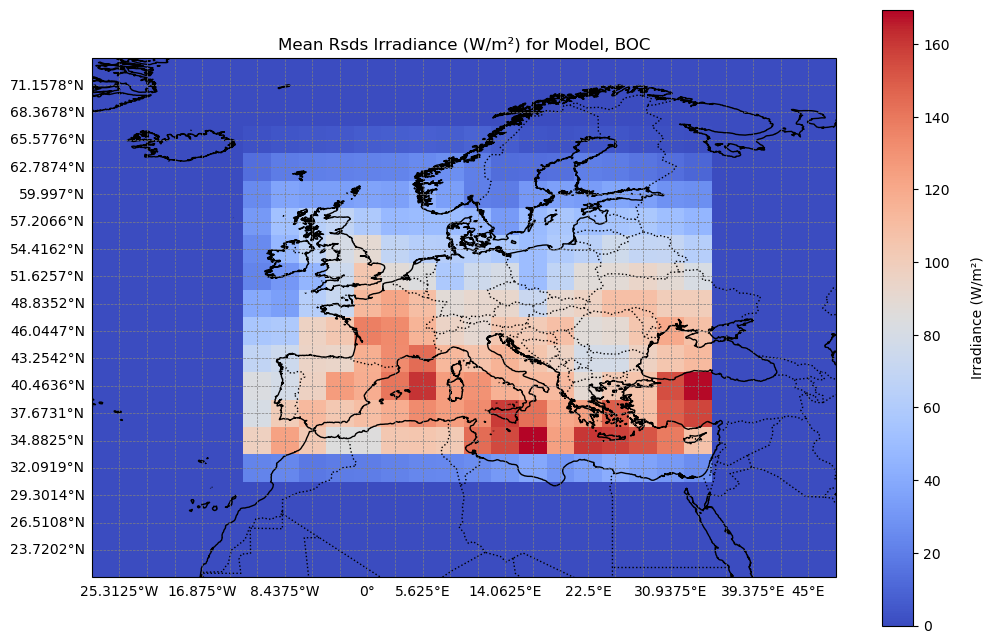

In [44]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Ensure these variables are defined before running the code
lon = rsdsdiff_era5_model.lon  # List or array of longitude ticks for gridlines
lat = rsdsdiff_era5_model.lat  # List or array of latitude ticks for gridlines

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon, lat, rsdsdiff_era5_model_mean,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto',  # Clip extreme outliers
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Mean Rsds Irradiance (W/m²) for Model, BOC")

# Add gridlines
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    xlocs=lon,  # Replace with actual longitude ticks
    ylocs=lat,  # Replace with actual latitude ticks
    x_inline=False, 
    y_inline=False
)
gridlines.top_labels = False  # Disable labels on the top
gridlines.right_labels = False  # Disable labels on the right

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical')
cbar.set_label('Irradiance (W/m²)', rotation=90, labelpad=15)

plt.show()

In [45]:
cutout = atlite.Cutout(path=filepath_model)

KeyError: None

In [46]:
print(ds_model_2014.attrs)

{'data_source': 'Processed data from CMIP6 runs', 'experiment': 'historical', 'source': 'CanESM5', 'variant_label': 'r1i1p2f1', 'data_written': '12/03/2025 13:59'}


In [47]:
print(ds_model_2014.coords)

Coordinates:
  * lon      (lon) float32 112B -28.12 -25.31 -22.5 -19.69 ... 42.19 45.0 47.81
  * lat      (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * time     (time) object 23kB '2014-01-01T01:30:00' ... '2014-12-31T22:30:00'


In [48]:
ds_model_2014['CRS']='EPSG:4326'

In [49]:
print(ds_model_2014.attrs)

{'data_source': 'Processed data from CMIP6 runs', 'experiment': 'historical', 'source': 'CanESM5', 'variant_label': 'r1i1p2f1', 'data_written': '12/03/2025 13:59'}


In [59]:
# Perform the resampling and apply an aggregation function (e.g., mean)
ds_era5_2016_resampled = ds_era5_2016.resample(time='3h', label="left", closed="right").mean()


In [61]:
ds_era5_2016_resampled

<xarray.Dataset> Size: 6GB
Dimensions:           (time: 2929, y: 157, x: 189)
Coordinates:
  * x                 (x) float64 2kB -12.0 -11.75 -11.5 ... 34.5 34.75 35.0
  * y                 (y) float64 1kB 33.0 33.25 33.5 33.75 ... 71.5 71.75 72.0
    lon               (x) float64 2kB -12.0 -11.75 -11.5 ... 34.5 34.75 35.0
    lat               (y) float64 1kB 33.0 33.25 33.5 33.75 ... 71.5 71.75 72.0
  * time              (time) datetime64[ns] 23kB 2015-12-31T21:00:00 ... 2016...
Data variables: (12/13)
    height            (time, y, x) float32 348MB 0.8357 1.065 ... 0.2621 0.2621
    wnd100m           (time, y, x) float32 348MB 2.92 2.465 ... 15.48 15.43
    wnd_azimuth       (time, y, x) float32 348MB 0.428 0.3882 ... 4.436 4.445
    roughness         (time, y, x) float32 348MB 2.426e-05 ... 0.0003473
    influx_toa        (time, y, x) float32 348MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    influx_direct     (time, y, x) float32 348MB 3.472e-05 ... 3.472e-05
    ...                ...
    albedo            (time, y, x) float32 348MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    solar_altitude    (time, y, x) float64 695MB -1.215 -1.218 ... -0.7115
    solar_azimuth     (time, y, x) float64 695MB 5.13 5.137 5.143 ... 3.224 3.23
    temperature       (time, y, x) float64 695MB 290.7 290.6 ... 271.1 271.0
    soil temperature  (time, y, x) float64 695MB 292.6 292.6 ... 278.3 278.3
    runoff            (time, y, x) float32 348MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    module:             era5
    prepared_features:  ['influx', 'temperature', 'runoff', 'height', 'wind']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-02-20 09:11:45 GMT by grib_to_netcdf-2.25.1: /op...

In [62]:
ds_era5_2016_resampled['influx_toa']=ds_model_2014['rsds']

In [63]:
ds_era5_2016_resampled

<xarray.Dataset> Size: 6GB
Dimensions:           (x: 189, y: 157, time: 2929, lat: 20, lon: 28)
Coordinates:
  * x                 (x) float64 2kB -12.0 -11.75 -11.5 ... 34.5 34.75 35.0
  * y                 (y) float64 1kB 33.0 33.25 33.5 33.75 ... 71.5 71.75 72.0
  * time              (time) datetime64[ns] 23kB 2015-12-31T21:00:00 ... 2016...
  * lon               (lon) float32 112B -28.12 -25.31 -22.5 ... 45.0 47.81
  * lat               (lat) float32 80B 20.93 23.72 26.51 ... 68.37 71.16 73.95
Data variables: (12/13)
    height            (time, y, x) float32 348MB 0.8357 1.065 ... 0.2621 0.2621
    wnd100m           (time, y, x) float32 348MB 2.92 2.465 ... 15.48 15.43
    wnd_azimuth       (time, y, x) float32 348MB 0.428 0.3882 ... 4.436 4.445
    roughness         (time, y, x) float32 348MB 2.426e-05 ... 0.0003473
    influx_toa        (time, lat, lon) float32 7MB nan nan nan ... nan nan nan
    influx_direct     (time, y, x) float32 348MB 3.472e-05 ... 3.472e-05
    ...                ...
    albedo            (time, y, x) float32 348MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    solar_altitude    (time, y, x) float64 695MB -1.215 -1.218 ... -0.7115
    solar_azimuth     (time, y, x) float64 695MB 5.13 5.137 5.143 ... 3.224 3.23
    temperature       (time, y, x) float64 695MB 290.7 290.6 ... 271.1 271.0
    soil temperature  (time, y, x) float64 695MB 292.6 292.6 ... 278.3 278.3
    runoff            (time, y, x) float32 348MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    module:             era5
    prepared_features:  ['influx', 'temperature', 'runoff', 'height', 'wind']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-02-20 09:11:45 GMT by grib_to_netcdf-2.25.1: /op...

In [64]:
# Count the total number of values in 'influx_toa'
total_values = ds_era5_2016_resampled['influx_toa'].size

# Count the number of NaN values in 'influx_toa'
num_nans = ds_era5_2016_resampled['influx_toa'].isnull().sum().item()

# Calculate the proportion of NaN values
proportion_nans = num_nans / total_values

print(f"Total values in 'influx_toa': {total_values}")
print(f"Number of NaN values in 'influx_toa': {num_nans}")
print(f"Proportion of NaN values: {proportion_nans:.2%}")

Total values in 'influx_toa': 1640240
Number of NaN values in 'influx_toa': 1640240
Proportion of NaN values: 100.00%


In [15]:
# Ensure the time coordinate is in datetime64 format
ds_model_2014 = ds_model_2014.assign_coords(time=np.array(ds_model_2014.time, dtype="datetime64[ns]"))

# Shift the time index backward by 1.5 hours to align with the start of the interval
ds_model_2014_shifted = ds_model_2014.assign_coords(
    time=ds_model_2014.time - np.timedelta64(90, "m")
)

# Resample to hourly intervals, repeating the 3-hourly values for each hour
ds_model_2014_h = ds_model_2014_shifted.resample(time="1H").ffill()

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


In [17]:
import pandas as pd
#Extract the minimum time as a scalar datetime64 value
start_time = ds_model_2014_h.time.min().values  # Use .values to get a datetime64 object

# Extend the time index to include the last hour of the year
new_time_index = pd.date_range(
    start=start_time,
    end="2014-12-31T23:00",
    freq="1H"
)

# Reindex the dataset to include the extended time index
ds_model_2014_h_reindexed = ds_model_2014_h.reindex(time=new_time_index)

# Manually forward-fill the last value (22:30) to 22:00 and 23:00
# Find the last valid time in the original dataset
last_valid_time = np.datetime64(ds_model_2014_h.time.max().values)  # Ensure it's datetime64[ns]
last_valid_value = ds_model_2014_h.sel(time=last_valid_time, method="nearest")

# Fill the missing values in the reindexed dataset
ds_model_2014_h_resampled = ds_model_2014_h_reindexed.ffill(dim="time")

# Ensure the last valid value is propagated to 22:00 and 23:00
ds_model_2014_h = ds_model_2014_h_resampled.fillna(last_valid_value)

/tmp/ipykernel_83462/246507330.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  new_time_index = pd.date_range(


In [ ]:
ds_era5_2016['total_influx']=ds_model_2014_h['rsds']
ds_era5_2016['influx_diffuse']=ds_model_2014_h['rsdsdiff']
ds_era5_2016['influx_direct']=ds_model_2014_h['rsds']-ds_model_2014_h['rsdsdiff']
#if I try to rewrite everything using the hourly data, it does not work because of different grids

In [20]:
ds_era5_2016

<xarray.Dataset> Size: 15GB
Dimensions:           (x: 189, y: 157, time: 8784, lon: 28, lat: 20)
Coordinates:
  * x                 (x) float64 2kB -12.0 -11.75 -11.5 ... 34.5 34.75 35.0
  * y                 (y) float64 1kB 33.0 33.25 33.5 33.75 ... 71.5 71.75 72.0
  * time              (time) datetime64[ns] 70kB 2016-01-01 ... 2016-12-31T23...
  * lon               (lon) float32 112B -28.12 -25.31 -22.5 ... 45.0 47.81
  * lat               (lat) float32 80B 20.93 23.72 26.51 ... 68.37 71.16 73.95
Data variables: (12/14)
    height            (y, x) float32 119kB ...
    wnd100m           (time, y, x) float32 1GB ...
    wnd_azimuth       (time, y, x) float32 1GB ...
    roughness         (time, y, x) float32 1GB ...
    influx_toa        (time, y, x) float32 1GB ...
    influx_direct     (time, lat, lon) float32 20MB nan nan nan ... nan nan nan
    ...                ...
    solar_altitude    (time, y, x) float64 2GB ...
    solar_azimuth     (time, y, x) float64 2GB ...
    temperature       (time, y, x) float64 2GB ...
    soil temperature  (time, y, x) float64 2GB ...
    runoff            (time, y, x) float32 1GB ...
    total_influx      (time, lat, lon) float32 20MB nan nan nan ... nan nan nan
Attributes:
    module:             era5
    prepared_features:  ['influx', 'temperature', 'runoff', 'height', 'wind']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-02-20 09:11:45 GMT by grib_to_netcdf-2.25.1: /op...